---
title: "Power in the USA"
description: "Visualizing the power lines and power plants across the US"
author: "Colin Hill"
date: "2024-11-25"
categories: [DuckDB, Overture Maps, Ibis, Datashader, Python]
page-layout: article
---

Electricity is supplied to our homes but we rarely know where it's coming from. To get a better sense of where power is being generated and how it's supplied to us, I wanted to visualize the power line network and the power plants. For this I'll use the infrastructure layer from [Overture Maps](https://docs.overturemaps.org/), along with [Ibis](https://ibis-project.org/) with the [DuckDB](https://ibis-project.org/backends/duckdb) backend to filter the parquet files, and finally plotting the data with [datashader](https://datashader.org/).

In [332]:
import ibis
from ibis import _
import geopandas as gpd
import shapely
import datashader as ds
from datashader.transfer_functions import shade, stack, set_background
%config InlineBackend.figure_formats = ['png']
# from PIL import Image

Retrieve the boundary for USA and clip to lower 48 states

In [252]:
admin_0 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_10m_admin_0_countries.geojson")
polygon = admin_0.loc[admin_0['ADM0_A3'].eq('USA'), 'geometry'].clip(shapely.box(-125, 24, -65, 49)).iloc[0]
crs = admin_0.crs

Now let's retrieve the power lines and stations from the Overture Maps infrastructure data. We can use Ibis with the DuckDB backend to filter the parquet files.

In [253]:
%%time

# Initialize DuckDB
con = ibis.duckdb.connect(extensions=['spatial'])

# Disable progress bar as it causes kernel to crash
con.raw_sql("SET enable_progress_bar = false");

# Load Overture Maps parquet data from s3
t = con.read_parquet("s3://overturemaps-us-west-2/release/2024-11-13.0/theme=base/type=infrastructure/*", table_name="infra-usa")

# Convert polygon for ibis
geometry_expr = ibis.literal(polygon)

# Filter to locations within the polygon, for the 'power' subtype
expr = (
    t
    .rename(infra_class="class")
    .filter(
        _.geometry.within(geometry_expr),
        _.subtype == "power",
        _.infra_class.isin(["plant", "power_line", "minor_line"])
    )
    .select(["names", "geometry", "infra_class"])
)

# Write to local parquet
con.to_parquet(expr, "usa-power.parquet")

CPU times: user 6min 51s, sys: 6.37 s, total: 6min 57s
Wall time: 2min 33s


For reference, I processed this data on a Macbook pro M1 with a 1Gbps up / 50Mbps down internet connection.

Now we can move on to visualizing the data. First, we'll clean up the geometries before plotting:

In [254]:
# Open local parquet with Geopandas (dataset is fairly small so this is performant)
power = gpd.read_parquet("usa-power.parquet")

In [255]:
power['geom_type'] = power['geometry'].geom_type
power.groupby(['infra_class', 'geom_type'])['geometry'].count()

infra_class  geom_type   
minor_line   LineString       93837
             Point                3
             Polygon             43
plant        LineString           2
             MultiPolygon      1380
             Point               26
             Polygon          10588
power_line   LineString      242367
             Point                2
             Polygon           1155
Name: geometry, dtype: int64

One would expect `power_line` and `minor_line` to be `LineString` type, which they almost entirely are. We can simply drop the other geometry types as there are so few. `plant` is mainly a mix of `Polygon` and `MultiPolygon`, which is expected, and for this project we'll drop the `LineString` and convert the `Points` to a `Polygon` with a simple buffer.

In [256]:
# Drop power lines that are not LineString
power = power.loc[~(power['infra_class'].isin(['power_line', 'minor_line']) & power['geom_type'].ne('LineString'))]

In [257]:
# Drop plant that are LineString
power = power.loc[~(power['infra_class'].eq('plant') & power['geom_type'].eq('LineString'))]

In [258]:
# Convert Points to a circle of radius 100m
index = power['infra_class'].eq('plant') & power['geom_type'].eq('Point')
power.loc[index, 'geometry'] = power.loc[index, 'geometry'].to_crs('EPSG:3857').buffer(100).to_crs(crs)

Now we can plot the data

In [ ]:
# Select subsets for power lines and plants
power_lines = power.loc[power['infra_class'].isin(['power_line', 'minor_line'])]
power_plants = power.loc[power['infra_class'].eq('plant')]

In [334]:
# Set plot limits from bounds of the polygon with a buffer
xmin, ymin, xmax, ymax = shapely.box(*polygon.bounds).buffer(1).bounds

width = 1200
height = 600

# Initialize datashader canvas
cvs = ds.Canvas(plot_width=width, plot_height=height, x_range=(xmin, xmax), y_range=(ymin, ymax))

# Rasterize/aggregate geometries
power_lines_agg = cvs.line(power_lines, geometry="geometry", line_width=0.1)
power_plants_agg = cvs.polygons(power_plants, geometry="geometry")
boundary_agg = cvs.polygons(gpd.GeoDataFrame({'geometry': polygon}, crs=crs, index=[0]), geometry="geometry")

# Stack and render image
img = stack(
    shade(power_lines_agg, cmap=ds.colors.color_lookup['mediumpurple'], alpha=255),
    shade(power_plants_agg, cmap=ds.colors.color_lookup['red'], alpha=255),
)

img = set_background(img, "black")

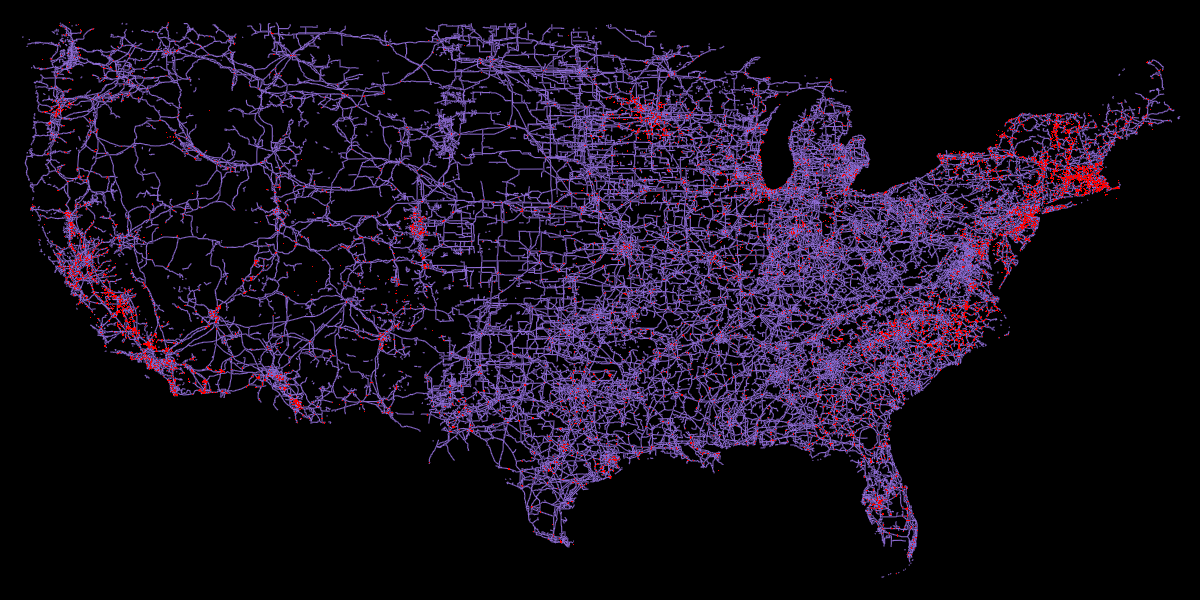

In [335]:
#| classes: preview-image
img.to_pil()

We can see that many power plants are (unsurprisingly) located near dense urban areas, especially along the eastern and western coasts.